# Стохастические дифференциальные уравнения

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Численные методы

Мы будем рассматривать одномерные и многомерные уравнения типа

$$
dX_t = \mu(t, X_t) dt   + \sigma(t,X_t) dW_t
$$

в смысле Ито. Со своими особенностями численные методы транслируются из области обыкновенных дифференциальных уравнений. Прежде всего, есть очень дешёвый метод, аналогичный явному методу Эйлера, который называется методом Эйлера-Маруямы. Решение вычисляется последовательно в дискретных точках $t_k$, где $X_{t_0}=x_0$ берётся из начального условия:

$$
X_{t_{k+1}} = b(t_k,X_{t_k}) \Delta t_{k} + \sigma(t_k,X_{t_k}) \Delta W_{k}.
$$

Поскольку мы имеем дело со случайными процессами, можно по-разному анализировать сходимость данного метода, одна из возможных метрик -- матожидание модуля максимальной ошибки.

In [59]:
class SDESolver:
    
    def __init__(self, b, sigma):
        self.b = b 
        self.sigma = sigma
    
    def step(self, x, t, tnext):
        """One integration step

        Raises:
            NotImplementedError: if not implemented
        """        
        raise NotImplementedError
    
    def solve(self, x0, ts):
        """Computes the solution on the given grid ts with x0 as initial condition

        Args:
            x0 float[]: initial condition (N,d,) or (d,)
            ts float[]: time grid (T,)
        Returns:
            xs float[]: approximated solution (N,d,T) at points ts
        """
        try:
            if(len(x0.shape)==1):
                x0 = x0[None, :]
        except:
            #a number?
            x0 = np.ones([1,1])*x0
                    
        xs = np.zeros([x0.shape[0], x0.shape[1], len(ts)])
        xs[...,0] = x0
        
        for i in np.arange(1,len(ts)):
            xs[...,i] = self.step(xs[...,i-1],ts[i-1],ts[i])
        
        return xs
    
class EulerSolver(SDESolver):
    
    def __init__(self,b,sigma):
        super(EulerSolver, self).__init__(b,sigma)
        
    def step(self, x, t, tnext):
        """Makes Euler step

        Args:
            x float[]: previous point (N,d)
            t float: previous time
            tnext float: next time
        """            
        #b (N,d)  x (N,d)   sigma (N,d,d)
        return x + self.b(t,x)*(tnext-t) + np.sum(self.sigma(t,x)*np.sqrt(tnext-t)*np.random.standard_normal(size=x.shape)[:,None,:],axis=-1)
        
        

Не забудем про библиотеку процессов, чтобы было с чем сопоставить. 

In [60]:
class WienerDriftProcess:
    
    def __init__(self, gamma=0, sigma=1):
        self.gamma = gamma
        self.sigma = sigma
        
    def sampleTrajs(self,x0,ts):
        '''
        Simulates trajectories of Wiener process
        Input
        float x0 -- initial value  (N,d)
        float[] ts -- times
        Returns
        float[] of shape (Ntraj,xs.shape[0],len(ts))
        '''
        xs=np.zeros(list(x0.shape)+list(ts.shape))
        xs[...,0]=x0
        for kk in np.arange(1,len(ts)):
            noises=np.random.standard_normal(size=x0.shape)
            xs[...,kk]=xs[...,kk-1] + self.sigma*np.sqrt(ts[kk]-ts[kk-1])*noises
    
        return xs + self.gamma*ts[None,:]
    
class GBMModel:
    
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.wien = WienerDriftProcess()
        
    def sampleTrajs(self,x0,ts):
        '''
        Simulates trajectories of GBM with parameters mu and sigma
        Input
        float[] x0 -- initial price, (N,d,)
        float[] ts -- times
        Returns
        float[] of shape (Ntraj,d,len(ts)) , trajectories
        '''
        wienProcs = self.wien.sampleTrajs(np.zeros_like(x0),ts)
        if(wienProcs.shape[1]>1):
                xs = x0[...,None] * np.exp((self.mu[...,None] - self.sigma[...,None]**2/2)*(ts-ts[0]) + self.sigma[...,None]*wienProcs)
        else:
                xs = x0[...,None] * np.exp((self.mu - self.sigma**2/2)*(ts-ts[0]) + self.sigma*wienProcs)
        return xs
        

In [91]:
a=0
b=1
Nt=20
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

mu=np.array([0.05])
sigma=np.array([0.2])

Ntrajs=3
x0=np.array([100])[None,:]*np.ones([Ntrajs,1])

gbm = GBMModel(mu,sigma)

#set the seed
np.random.seed(100500)
trajs = gbm.sampleTrajs(x0,ts)
print(trajs.shape)

(3, 1, 21)


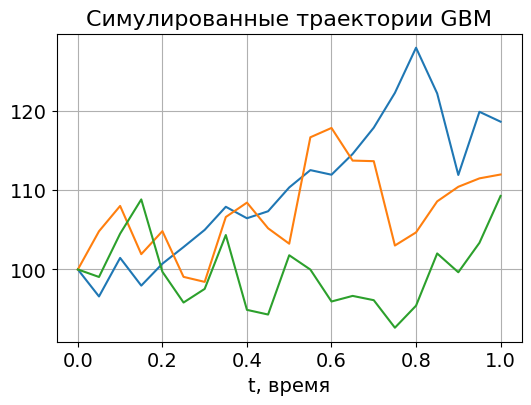

In [95]:
#plots

f, ax1 = plt.subplots(figsize=(6,4))

ax1.grid()
ax1.set_title('Симулированные траектории GBM',fontsize=16)
ax1.set_xlabel('t, время',fontsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.plot(ts,trajs[:,0,:].T)

In [93]:
#set the seed
np.random.seed(100500)


def bGBM(t,x):
    return mu*x
def sigmaGBM(t,x):
    return sigma*x

solver = EulerSolver(bGBM,sigmaGBM)

apprTrajs = solver.solve(x0,ts)
print(apprTrajs.shape)

(3, 1, 21)


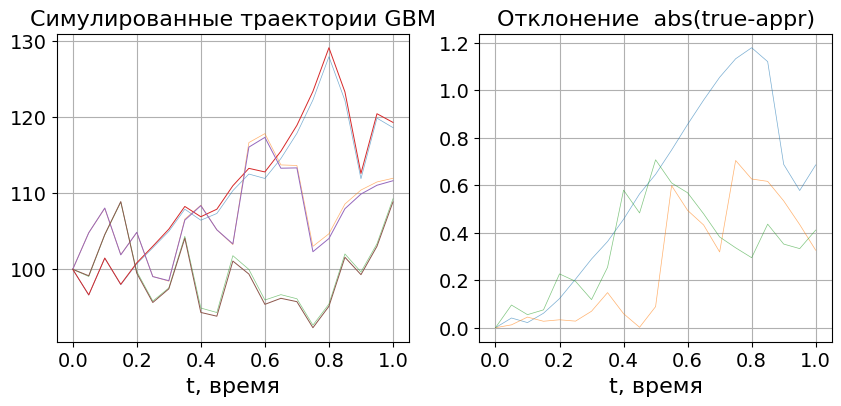

In [94]:
#plots

f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.grid()
ax1.set_title('Симулированные траектории GBM',fontsize=16)
ax1.set_xlabel('t, время',fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.plot(ts,trajs[:,0,:].T,alpha=0.6,linewidth=0.5)
plt.gca().set_prop_cycle(None)
ax1.plot(ts,apprTrajs[:,0,:].T,linewidth=0.7)


ax2.grid()
ax2.set_title('Отклонение  abs(true-appr)',fontsize=16)
ax2.set_xlabel('t, время',fontsize=16)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.plot(ts,np.abs(trajs[:,0,:].T-apprTrajs[:,0,:].T),alpha=0.6,linewidth=0.5)

## Процесс Орнштейна-Уленбека

Рассмотрим вариант процесса с возвратом к заданному среднему $\mu$. Мы ранее выражали этот процесс через интеграл Римана от Винеровского  процесса, а ещё как гауссовский процесс путём подсчёта его ковариационной функции.

$$
dX_t = \theta (\mu-X_t) dt + \sigma dW_t.
$$

Решим это уравнение численно с помощью изученного метода и проверим, есть ли эффект возврата к среднему.

In [115]:
a=0
b=1000
Nt=10000
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

mu=0.15 # стационарная ставка?
theta = 0.1 # скорость стремления
sigma =0.02 #волатильность ставки

def bOU(t,x):
    return theta*(mu-x)
def sigmaOU(t,x):
    return sigma*np.ones_like(x)

solver = EulerSolver(bOU,sigmaOU)

Ntrajs=3
x0=np.array([0.95])[None,:]*np.ones([Ntrajs,1])


apprTrajs = solver.solve(x0,ts)
print(apprTrajs.shape)

(3, 1, 10001)


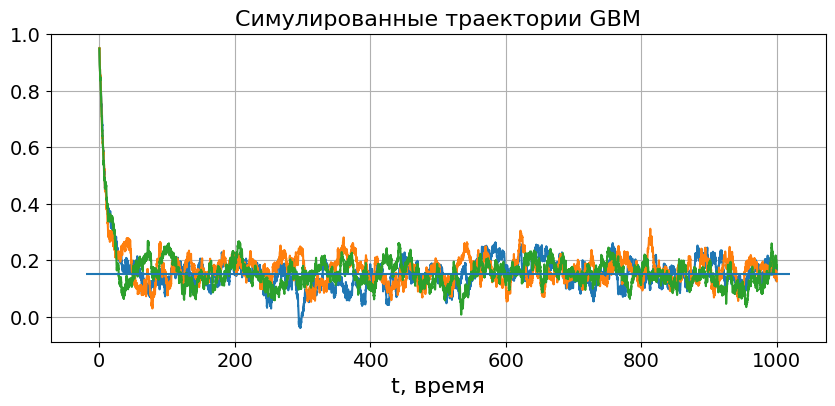

In [116]:
#plots
offset=20
f, ax1 = plt.subplots(figsize=(10,4))

ax1.grid()
ax1.set_title('Симулированные траектории GBM',fontsize=16)
ax1.set_xlabel('t, время',fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.plot(ts,apprTrajs[:,0,:].T)
ax1.hlines(mu, a-offset, b+offset, colors=None, linestyles='solid')